In [1]:
from data import Data
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

Strategy
-
As we have seen in RNN+LSTM file, it is possible to compute periodic wave and the noise separately. Here, we take slightly different approach; learn the simple sine wave with a complex LSTM model and use it as initialization of the noisy data.


1. Compute periodic sine wave from data using simple RNN (hidden_size=2).
2. Construct a complex LSTM model (hidden_size=40).
3. Learn the sine wave with the LSTM model for epoch<5000 (loss function wrt sine).
4. Learn the actual data (loss function wrt data)

In this way, we use sine without noise as the initialization of the LSTM model. So we first learn how to initialize our model.

Here, we first compute periodic wave from the data, which is much simpler as it ignores the noise, 

In [3]:
class RNN_model(nn.Module): 
    def __init__(self, num_inputs, num_hiddens,num_out=1):
        super().__init__()
        self.num_inputs = num_inputs
        self.num_hiddens = num_hiddens
        self.rnn = nn.RNN(num_inputs, num_hiddens, bias=False)
        self.linear = nn.Linear(num_hiddens, num_out, bias=False)
    def forward(self, X, H):
        X_0 = torch.zeros(len(X),1)
        X_0[0] = 1.
        state, H = self.rnn(X_0,H)
        pred = self.linear(state)
        return pred, H

In [4]:
def rnn_train(model, X, optimizer, criterion, H, epoch):
    model.train()
    optimizer.zero_grad()
    y_hat,H = model(X, H)
    loss = criterion(X,y_hat)
    loss.backward()
    optimizer.step()
    if epoch % 1000 == 0:
        print(torch.sqrt(loss.detach()))

In [7]:
data = Data(0.1,100,0.2)
X = data.x.unsqueeze(-1)
mse_loss = nn.MSELoss()
rnn_model = RNN_model(1,2) #hidden state of size 2 is enough for sin
optimizer = torch.optim.Adam(rnn_model.parameters(), lr=0.01)
for epoch in range(5000):
    H = torch.zeros(1,2)
    rnn_train(rnn_model, X, optimizer, mse_loss, H, epoch)

tensor(0.7591)
tensor(0.1726)
tensor(0.1715)
tensor(0.1715)
tensor(0.1713)


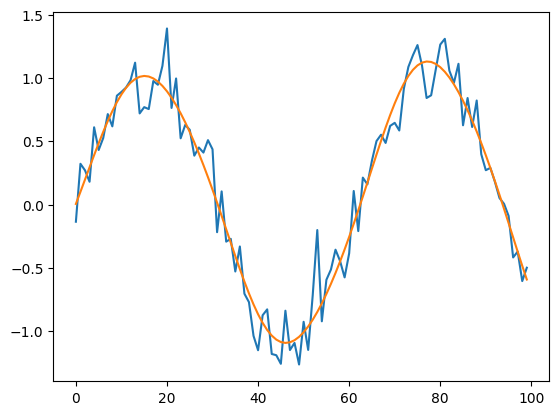

In [9]:
X_zeros = torch.zeros(100,1)
H = torch.zeros(1,2)
rnn_out,H_first_out = rnn_model(X_zeros,H)
rnn_out = rnn_out.detach()
plt.plot(X)
plt.plot(rnn_out)

In [19]:
class LSTM_model(nn.Module):  
    def __init__(self, num_inputs, num_hiddens,num_out=1):
        super().__init__()
        self.num_inputs = num_inputs
        self.num_hiddens = num_hiddens
        self.LSTM = nn.LSTM(num_inputs, num_hiddens, bias=False)
        self.linear = nn.Linear(num_hiddens, num_out, bias=False)
    def forward(self, X, H, c):
        X_0 = torch.zeros(len(X),1)
        X_0[0] = 1.
        out, (H, c) = self.LSTM(X_0,(H,c))
        pred = self.linear(out)
        return pred, H

In [20]:
def train(model, X, optimizer, criterion, H, c, epoch):
    model.train()
    optimizer.zero_grad()
    if epoch < 5000:
        H_rnn = torch.zeros(1,2)
        y, _ = rnn_model(X,H_rnn)
        y = y.detach()
    else:
        y = X
    y_hat, H = model(X, H, c)
    loss = criterion(y,y_hat)
    loss.backward()
    optimizer.step()
    if epoch % 1000 == 0:
        print(torch.sqrt(loss.detach()))

In [21]:
mse_loss = nn.MSELoss('sum')
lstm_model = LSTM_model(1,40)
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=0.001)
for epoch in range(20000):
    H = torch.zeros(1,40)
    c = torch.zeros(1,40)
    train(lstm_model, X, optimizer, mse_loss, H, c,epoch)

tensor(0.7402)
tensor(0.0398)
tensor(0.0201)
tensor(0.0156)
tensor(0.0125)
tensor(0.1722)
tensor(0.1649)
tensor(0.1628)
tensor(0.1511)
tensor(0.1451)
tensor(0.1432)
tensor(0.1374)
tensor(0.1268)
tensor(0.1120)
tensor(0.1041)
tensor(0.0933)
tensor(0.0874)
tensor(0.0845)
tensor(0.0809)
tensor(0.0723)


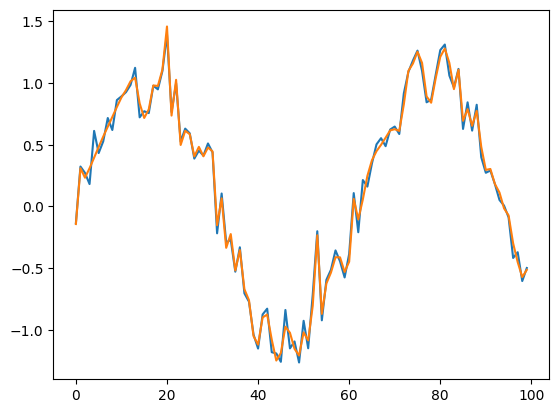

In [24]:
X_zeros = torch.zeros(250,1)
H_zeros = torch.zeros(1,40)
c_zeros = torch.zeros(1,40)
output, H_out = lstm_model(X,H_zeros,c_zeros)
output = output.detach()
plt.plot(X)
plt.plot(output)

Looks good!!!